In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output has two classes: whether stock will go up or down or stay constant X days after last input.

In [1]:
OBSERVATION_TIME = 200
PREDICTION_AFTER_DAYS = 20
EPOCHS = 300
TEST_SIZE = 0.1
RANDOM_SPLIT = False
NORMALIZED_CHUNKS = True

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

Parameter RANDOM_SPLIT is responsible for that feature. If True, then data set is split randomly into train/test set (network knows sets from the future). When False, then split is chronological - network works like in real world.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/AAPL.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000


In [3]:
# PREPROCESSING

def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

In [4]:
observed_chunks[0]

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000
...,...,...,...,...,...,...,...,...
195,195,2006-02-27,10.284286,10.302857,10.092857,10.141429,8.779409,197810200
196,196,2006-02-28,10.225715,10.342857,9.728572,9.784286,8.470230,316745100
197,197,2006-03-01,9.834286,9.927143,9.717143,9.871428,8.545672,190954400
198,198,2006-03-02,9.855714,9.998571,9.810000,9.944285,8.608742,156318400


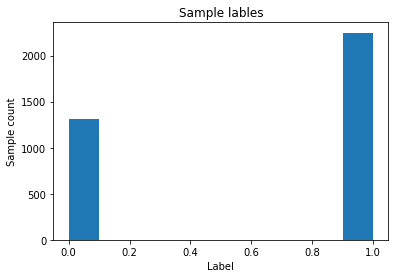

1    2248
0    1307
dtype: int64

In [19]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.title('Sample lables')
plt.ylabel('Sample count')
plt.xlabel('Label')
plt.show()

pd.Series(observation_results).value_counts()

In [14]:
# NORMALIZATION

def normalize_chunk(chunk):
    df = chunk.copy()
    for label_to_normalize in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
        np_arr = df[label_to_normalize].to_numpy()
        df[label_to_normalize] = pd.Series((np.array(np_arr) - np.mean(np_arr)) / np.std(np_arr))
    return df

def normalize_chunks(chunks):
    return list(map(lambda x: normalize_chunk(x), chunks))

observed_chunks = normalize_chunks(observed_chunks) if NORMALIZED_CHUNKS else observed_chunks

In [18]:
import plotly.express as px

fig = px.line(observed_chunks[100], x="Date", y=['Open', 'High', 'Low', 'Close', 'Adj Close'])
fig.show()

observed_chunks[0]

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2005-05-18,-1.432292,-1.327983,-1.441202,-1.422671,-1.422671,-0.117164
1,1,2005-05-19,-1.409183,-1.319680,-1.384520,-1.301647,-1.301647,0.294000
2,2,2005-05-20,-1.306242,-1.321755,-1.283355,-1.301647,-1.301647,-0.600955
3,3,2005-05-23,-1.264226,-1.166078,-1.236001,-1.145235,-1.145235,0.949525
4,4,2005-05-24,-1.152182,-1.159851,-1.151337,-1.149481,-1.149481,-0.230870
...,...,...,...,...,...,...,...,...
195,195,2006-02-27,1.126510,1.063220,1.117357,1.065055,1.065055,0.288952
196,196,2006-02-28,1.097799,1.082594,0.934398,0.888118,0.888118,1.539325
197,197,2006-03-01,0.905924,0.881251,0.928658,0.931290,0.931292,0.216876
198,198,2006-03-02,0.916428,0.915846,0.975295,0.967385,0.967385,-0.147255


In [7]:
# TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].to_numpy(), observed_chunks)))
Y = np.array(observation_results).astype('float32')

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3199, 200, 6), (3199,), (356, 200, 6), (356,))

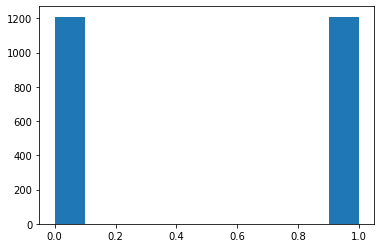

0.0    1209
1.0    1209
dtype: int64

In [8]:
# UNDERSAMPLING TRAINING SET

import random

def undersample_and_shuffle(X, Y):
    count_class_1, count_class_0 = pd.Series(Y).value_counts()

    lower_count = count_class_0 if count_class_0 < count_class_1 else count_class_1
    lower_class = 0 if count_class_0 < count_class_1 else 1
    
    diff = abs(count_class_0 - count_class_1)
    
    vec0 = random.sample([(x, y) for x, y in zip(X, Y) if y == 0], lower_count)
    vec1 = random.sample([(x, y) for x, y in zip(X, Y) if y == 1], lower_count)

    
    vec = vec0 + vec1
    random.shuffle(vec)
    return np.array(list(map(lambda x: x[0], vec))), np.array(list(map(lambda x: x[1], vec)))
    
X_train_balanced, Y_train_balanced = undersample_and_shuffle(X_train, Y_train)

plt.hist(Y_train_balanced)
plt.show()

pd.Series(Y_train_balanced).value_counts()

In [9]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (OBSERVATION_TIME, 6), filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 200, 16)           496       
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 16)           64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 200, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 8)            648       
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 8)            32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 200, 8)           

In [10]:
from keras.optimizers import Nadam
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=METRICS)

In [11]:

history = model.fit(x=X_train_balanced, 
                    y=Y_train_balanced, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True)

model.save("model-binary.h5")
model.save_weights('model-binry-weights.h5')

Train on 2418 samples, validate on 356 samples
Epoch 1/300
2418/2418 [==============================] - 1s 451us/step - loss: 0.7751 - tp: 656.0000 - fp: 568.0000 - tn: 641.0000 - fn: 553.0000 - accuracy: 0.5364 - precision: 0.5359 - recall: 0.5426 - auc: 0.5555 - val_loss: 0.8958 - val_tp: 100.0000 - val_fp: 32.0000 - val_tn: 66.0000 - val_fn: 158.0000 - val_accuracy: 0.4663 - val_precision: 0.7576 - val_recall: 0.3876 - val_auc: 0.4908
Epoch 2/300
2418/2418 [==============================] - 0s 163us/step - loss: 0.7283 - tp: 702.0000 - fp: 542.0000 - tn: 667.0000 - fn: 507.0000 - accuracy: 0.5662 - precision: 0.5643 - recall: 0.5806 - auc: 0.5938 - val_loss: 1.0895 - val_tp: 93.0000 - val_fp: 31.0000 - val_tn: 67.0000 - val_fn: 165.0000 - val_accuracy: 0.4494 - val_precision: 0.7500 - val_recall: 0.3605 - val_auc: 0.5033
Epoch 3/300
2418/2418 [==============================] - 0s 169us/step - loss: 0.6812 - tp: 713.0000 - fp: 470.0000 - tn: 739.0000 - fn: 496.0000 - accuracy: 0.6005

Epoch 22/300
2418/2418 [==============================] - 0s 153us/step - loss: 0.4957 - tp: 909.0000 - fp: 265.0000 - tn: 944.0000 - fn: 300.0000 - accuracy: 0.7663 - precision: 0.7743 - recall: 0.7519 - auc: 0.8445 - val_loss: 0.7778 - val_tp: 97.0000 - val_fp: 27.0000 - val_tn: 71.0000 - val_fn: 161.0000 - val_accuracy: 0.4719 - val_precision: 0.7823 - val_recall: 0.3760 - val_auc: 0.6145
Epoch 23/300
2418/2418 [==============================] - 0s 164us/step - loss: 0.4837 - tp: 926.0000 - fp: 256.0000 - tn: 953.0000 - fn: 283.0000 - accuracy: 0.7771 - precision: 0.7834 - recall: 0.7659 - auc: 0.8562 - val_loss: 0.8052 - val_tp: 103.0000 - val_fp: 25.0000 - val_tn: 73.0000 - val_fn: 155.0000 - val_accuracy: 0.4944 - val_precision: 0.8047 - val_recall: 0.3992 - val_auc: 0.6259
Epoch 24/300
2418/2418 [==============================] - 0s 167us/step - loss: 0.4785 - tp: 946.0000 - fp: 262.0000 - tn: 947.0000 - fn: 263.0000 - accuracy: 0.7829 - precision: 0.7831 - recall: 0.7825 - auc:

Epoch 43/300
2418/2418 [==============================] - 0s 147us/step - loss: 0.3680 - tp: 1015.0000 - fp: 192.0000 - tn: 1017.0000 - fn: 194.0000 - accuracy: 0.8404 - precision: 0.8409 - recall: 0.8395 - auc: 0.9230 - val_loss: 0.7462 - val_tp: 130.0000 - val_fp: 34.0000 - val_tn: 64.0000 - val_fn: 128.0000 - val_accuracy: 0.5449 - val_precision: 0.7927 - val_recall: 0.5039 - val_auc: 0.6540
Epoch 44/300
2418/2418 [==============================] - 0s 143us/step - loss: 0.3712 - tp: 1035.0000 - fp: 179.0000 - tn: 1030.0000 - fn: 174.0000 - accuracy: 0.8540 - precision: 0.8526 - recall: 0.8561 - auc: 0.9216 - val_loss: 0.7168 - val_tp: 133.0000 - val_fp: 24.0000 - val_tn: 74.0000 - val_fn: 125.0000 - val_accuracy: 0.5815 - val_precision: 0.8471 - val_recall: 0.5155 - val_auc: 0.7275
Epoch 45/300
2418/2418 [==============================] - 0s 142us/step - loss: 0.3529 - tp: 1039.0000 - fp: 185.0000 - tn: 1024.0000 - fn: 170.0000 - accuracy: 0.8532 - precision: 0.8489 - recall: 0.8594

Epoch 64/300
2418/2418 [==============================] - 0s 139us/step - loss: 0.2884 - tp: 1070.0000 - fp: 138.0000 - tn: 1071.0000 - fn: 139.0000 - accuracy: 0.8854 - precision: 0.8858 - recall: 0.8850 - auc: 0.9549 - val_loss: 0.7550 - val_tp: 149.0000 - val_fp: 35.0000 - val_tn: 63.0000 - val_fn: 109.0000 - val_accuracy: 0.5955 - val_precision: 0.8098 - val_recall: 0.5775 - val_auc: 0.6910
Epoch 65/300
2418/2418 [==============================] - 0s 143us/step - loss: 0.2873 - tp: 1069.0000 - fp: 133.0000 - tn: 1076.0000 - fn: 140.0000 - accuracy: 0.8871 - precision: 0.8894 - recall: 0.8842 - auc: 0.9545 - val_loss: 0.6554 - val_tp: 141.0000 - val_fp: 7.0000 - val_tn: 91.0000 - val_fn: 117.0000 - val_accuracy: 0.6517 - val_precision: 0.9527 - val_recall: 0.5465 - val_auc: 0.8131
Epoch 66/300
2418/2418 [==============================] - 0s 140us/step - loss: 0.2887 - tp: 1078.0000 - fp: 133.0000 - tn: 1076.0000 - fn: 131.0000 - accuracy: 0.8908 - precision: 0.8902 - recall: 0.8916 

Epoch 85/300
2418/2418 [==============================] - 0s 159us/step - loss: 0.2308 - tp: 1115.0000 - fp: 112.0000 - tn: 1097.0000 - fn: 94.0000 - accuracy: 0.9148 - precision: 0.9087 - recall: 0.9222 - auc: 0.9723 - val_loss: 0.7287 - val_tp: 153.0000 - val_fp: 20.0000 - val_tn: 78.0000 - val_fn: 105.0000 - val_accuracy: 0.6489 - val_precision: 0.8844 - val_recall: 0.5930 - val_auc: 0.7550
Epoch 86/300
2418/2418 [==============================] - 0s 166us/step - loss: 0.2372 - tp: 1098.0000 - fp: 94.0000 - tn: 1115.0000 - fn: 111.0000 - accuracy: 0.9152 - precision: 0.9211 - recall: 0.9082 - auc: 0.9683 - val_loss: 0.6876 - val_tp: 159.0000 - val_fp: 19.0000 - val_tn: 79.0000 - val_fn: 99.0000 - val_accuracy: 0.6685 - val_precision: 0.8933 - val_recall: 0.6163 - val_auc: 0.7997
Epoch 87/300
2418/2418 [==============================] - 0s 171us/step - loss: 0.2419 - tp: 1096.0000 - fp: 114.0000 - tn: 1095.0000 - fn: 113.0000 - accuracy: 0.9061 - precision: 0.9058 - recall: 0.9065 - 

Epoch 106/300
2418/2418 [==============================] - 0s 167us/step - loss: 0.2109 - tp: 1108.0000 - fp: 93.0000 - tn: 1116.0000 - fn: 101.0000 - accuracy: 0.9198 - precision: 0.9226 - recall: 0.9165 - auc: 0.9749 - val_loss: 0.7658 - val_tp: 162.0000 - val_fp: 26.0000 - val_tn: 72.0000 - val_fn: 96.0000 - val_accuracy: 0.6573 - val_precision: 0.8617 - val_recall: 0.6279 - val_auc: 0.7466
Epoch 107/300
2418/2418 [==============================] - 0s 162us/step - loss: 0.1986 - tp: 1120.0000 - fp: 90.0000 - tn: 1119.0000 - fn: 89.0000 - accuracy: 0.9260 - precision: 0.9256 - recall: 0.9264 - auc: 0.9791 - val_loss: 0.8823 - val_tp: 170.0000 - val_fp: 46.0000 - val_tn: 52.0000 - val_fn: 88.0000 - val_accuracy: 0.6236 - val_precision: 0.7870 - val_recall: 0.6589 - val_auc: 0.6814
Epoch 108/300
2418/2418 [==============================] - 0s 161us/step - loss: 0.2104 - tp: 1119.0000 - fp: 99.0000 - tn: 1110.0000 - fn: 90.0000 - accuracy: 0.9218 - precision: 0.9187 - recall: 0.9256 - a

Epoch 127/300
2418/2418 [==============================] - 0s 164us/step - loss: 0.1809 - tp: 1128.0000 - fp: 78.0000 - tn: 1131.0000 - fn: 81.0000 - accuracy: 0.9342 - precision: 0.9353 - recall: 0.9330 - auc: 0.9816 - val_loss: 0.8059 - val_tp: 177.0000 - val_fp: 34.0000 - val_tn: 64.0000 - val_fn: 81.0000 - val_accuracy: 0.6770 - val_precision: 0.8389 - val_recall: 0.6860 - val_auc: 0.7352
Epoch 128/300
2418/2418 [==============================] - 0s 172us/step - loss: 0.1817 - tp: 1127.0000 - fp: 79.0000 - tn: 1130.0000 - fn: 82.0000 - accuracy: 0.9334 - precision: 0.9345 - recall: 0.9322 - auc: 0.9816 - val_loss: 0.7573 - val_tp: 172.0000 - val_fp: 30.0000 - val_tn: 68.0000 - val_fn: 86.0000 - val_accuracy: 0.6742 - val_precision: 0.8515 - val_recall: 0.6667 - val_auc: 0.7707
Epoch 129/300
2418/2418 [==============================] - 0s 170us/step - loss: 0.1763 - tp: 1142.0000 - fp: 80.0000 - tn: 1129.0000 - fn: 67.0000 - accuracy: 0.9392 - precision: 0.9345 - recall: 0.9446 - au

Epoch 148/300
2418/2418 [==============================] - 0s 147us/step - loss: 0.1522 - tp: 1140.0000 - fp: 63.0000 - tn: 1146.0000 - fn: 69.0000 - accuracy: 0.9454 - precision: 0.9476 - recall: 0.9429 - auc: 0.9875 - val_loss: 0.8271 - val_tp: 172.0000 - val_fp: 40.0000 - val_tn: 58.0000 - val_fn: 86.0000 - val_accuracy: 0.6461 - val_precision: 0.8113 - val_recall: 0.6667 - val_auc: 0.7166
Epoch 149/300
2418/2418 [==============================] - 0s 149us/step - loss: 0.1728 - tp: 1136.0000 - fp: 88.0000 - tn: 1121.0000 - fn: 73.0000 - accuracy: 0.9334 - precision: 0.9281 - recall: 0.9396 - auc: 0.9826 - val_loss: 0.8458 - val_tp: 168.0000 - val_fp: 23.0000 - val_tn: 75.0000 - val_fn: 90.0000 - val_accuracy: 0.6826 - val_precision: 0.8796 - val_recall: 0.6512 - val_auc: 0.7600
Epoch 150/300
2418/2418 [==============================] - 0s 150us/step - loss: 0.1617 - tp: 1132.0000 - fp: 69.0000 - tn: 1140.0000 - fn: 77.0000 - accuracy: 0.9396 - precision: 0.9425 - recall: 0.9363 - au

Epoch 169/300
2418/2418 [==============================] - 0s 154us/step - loss: 0.1509 - tp: 1142.0000 - fp: 67.0000 - tn: 1142.0000 - fn: 67.0000 - accuracy: 0.9446 - precision: 0.9446 - recall: 0.9446 - auc: 0.9869 - val_loss: 0.8483 - val_tp: 175.0000 - val_fp: 42.0000 - val_tn: 56.0000 - val_fn: 83.0000 - val_accuracy: 0.6489 - val_precision: 0.8065 - val_recall: 0.6783 - val_auc: 0.7365
Epoch 170/300
2418/2418 [==============================] - 0s 160us/step - loss: 0.1500 - tp: 1139.0000 - fp: 66.0000 - tn: 1143.0000 - fn: 70.0000 - accuracy: 0.9438 - precision: 0.9452 - recall: 0.9421 - auc: 0.9873 - val_loss: 0.8663 - val_tp: 162.0000 - val_fp: 31.0000 - val_tn: 67.0000 - val_fn: 96.0000 - val_accuracy: 0.6433 - val_precision: 0.8394 - val_recall: 0.6279 - val_auc: 0.7554
Epoch 171/300
2418/2418 [==============================] - 0s 158us/step - loss: 0.1367 - tp: 1155.0000 - fp: 56.0000 - tn: 1153.0000 - fn: 54.0000 - accuracy: 0.9545 - precision: 0.9538 - recall: 0.9553 - au

Epoch 190/300
2418/2418 [==============================] - 0s 168us/step - loss: 0.1316 - tp: 1149.0000 - fp: 55.0000 - tn: 1154.0000 - fn: 60.0000 - accuracy: 0.9524 - precision: 0.9543 - recall: 0.9504 - auc: 0.9903 - val_loss: 0.8922 - val_tp: 159.0000 - val_fp: 20.0000 - val_tn: 78.0000 - val_fn: 99.0000 - val_accuracy: 0.6657 - val_precision: 0.8883 - val_recall: 0.6163 - val_auc: 0.7656
Epoch 191/300
2418/2418 [==============================] - 0s 165us/step - loss: 0.1263 - tp: 1148.0000 - fp: 58.0000 - tn: 1151.0000 - fn: 61.0000 - accuracy: 0.9508 - precision: 0.9519 - recall: 0.9495 - auc: 0.9922 - val_loss: 0.9549 - val_tp: 165.0000 - val_fp: 39.0000 - val_tn: 59.0000 - val_fn: 93.0000 - val_accuracy: 0.6292 - val_precision: 0.8088 - val_recall: 0.6395 - val_auc: 0.7211
Epoch 192/300
2418/2418 [==============================] - 0s 162us/step - loss: 0.1276 - tp: 1148.0000 - fp: 51.0000 - tn: 1158.0000 - fn: 61.0000 - accuracy: 0.9537 - precision: 0.9575 - recall: 0.9495 - au

Epoch 211/300
2418/2418 [==============================] - 1s 238us/step - loss: 0.1292 - tp: 1152.0000 - fp: 55.0000 - tn: 1154.0000 - fn: 57.0000 - accuracy: 0.9537 - precision: 0.9544 - recall: 0.9529 - auc: 0.9899 - val_loss: 0.9429 - val_tp: 154.0000 - val_fp: 25.0000 - val_tn: 73.0000 - val_fn: 104.0000 - val_accuracy: 0.6376 - val_precision: 0.8603 - val_recall: 0.5969 - val_auc: 0.7519
Epoch 212/300
2418/2418 [==============================] - 0s 205us/step - loss: 0.1226 - tp: 1155.0000 - fp: 53.0000 - tn: 1156.0000 - fn: 54.0000 - accuracy: 0.9557 - precision: 0.9561 - recall: 0.9553 - auc: 0.9913 - val_loss: 0.9904 - val_tp: 167.0000 - val_fp: 32.0000 - val_tn: 66.0000 - val_fn: 91.0000 - val_accuracy: 0.6545 - val_precision: 0.8392 - val_recall: 0.6473 - val_auc: 0.7307
Epoch 213/300
2418/2418 [==============================] - 0s 200us/step - loss: 0.1115 - tp: 1156.0000 - fp: 48.0000 - tn: 1161.0000 - fn: 53.0000 - accuracy: 0.9582 - precision: 0.9601 - recall: 0.9562 - a

Epoch 232/300
2418/2418 [==============================] - 0s 183us/step - loss: 0.1057 - tp: 1164.0000 - fp: 43.0000 - tn: 1166.0000 - fn: 45.0000 - accuracy: 0.9636 - precision: 0.9644 - recall: 0.9628 - auc: 0.9934 - val_loss: 0.9922 - val_tp: 175.0000 - val_fp: 32.0000 - val_tn: 66.0000 - val_fn: 83.0000 - val_accuracy: 0.6770 - val_precision: 0.8454 - val_recall: 0.6783 - val_auc: 0.7346
Epoch 233/300
2418/2418 [==============================] - 0s 182us/step - loss: 0.1063 - tp: 1163.0000 - fp: 42.0000 - tn: 1167.0000 - fn: 46.0000 - accuracy: 0.9636 - precision: 0.9651 - recall: 0.9620 - auc: 0.9940 - val_loss: 0.9535 - val_tp: 158.0000 - val_fp: 32.0000 - val_tn: 66.0000 - val_fn: 100.0000 - val_accuracy: 0.6292 - val_precision: 0.8316 - val_recall: 0.6124 - val_auc: 0.7285
Epoch 234/300
2418/2418 [==============================] - 0s 193us/step - loss: 0.1114 - tp: 1149.0000 - fp: 43.0000 - tn: 1166.0000 - fn: 60.0000 - accuracy: 0.9574 - precision: 0.9639 - recall: 0.9504 - a

Epoch 253/300
2418/2418 [==============================] - 0s 155us/step - loss: 0.0909 - tp: 1167.0000 - fp: 37.0000 - tn: 1172.0000 - fn: 42.0000 - accuracy: 0.9673 - precision: 0.9693 - recall: 0.9653 - auc: 0.9960 - val_loss: 0.8825 - val_tp: 148.0000 - val_fp: 30.0000 - val_tn: 68.0000 - val_fn: 110.0000 - val_accuracy: 0.6067 - val_precision: 0.8315 - val_recall: 0.5736 - val_auc: 0.7401
Epoch 254/300
2418/2418 [==============================] - 0s 152us/step - loss: 0.0945 - tp: 1165.0000 - fp: 37.0000 - tn: 1172.0000 - fn: 44.0000 - accuracy: 0.9665 - precision: 0.9692 - recall: 0.9636 - auc: 0.9952 - val_loss: 1.0951 - val_tp: 151.0000 - val_fp: 34.0000 - val_tn: 64.0000 - val_fn: 107.0000 - val_accuracy: 0.6039 - val_precision: 0.8162 - val_recall: 0.5853 - val_auc: 0.7015
Epoch 255/300
2418/2418 [==============================] - 0s 154us/step - loss: 0.0970 - tp: 1167.0000 - fp: 40.0000 - tn: 1169.0000 - fn: 42.0000 - accuracy: 0.9661 - precision: 0.9669 - recall: 0.9653 - 

Epoch 274/300
2418/2418 [==============================] - 0s 159us/step - loss: 0.0896 - tp: 1170.0000 - fp: 38.0000 - tn: 1171.0000 - fn: 39.0000 - accuracy: 0.9682 - precision: 0.9685 - recall: 0.9677 - auc: 0.9954 - val_loss: 1.0526 - val_tp: 163.0000 - val_fp: 35.0000 - val_tn: 63.0000 - val_fn: 95.0000 - val_accuracy: 0.6348 - val_precision: 0.8232 - val_recall: 0.6318 - val_auc: 0.7199
Epoch 275/300
2418/2418 [==============================] - 0s 155us/step - loss: 0.0829 - tp: 1172.0000 - fp: 30.0000 - tn: 1179.0000 - fn: 37.0000 - accuracy: 0.9723 - precision: 0.9750 - recall: 0.9694 - auc: 0.9964 - val_loss: 1.0343 - val_tp: 156.0000 - val_fp: 26.0000 - val_tn: 72.0000 - val_fn: 102.0000 - val_accuracy: 0.6404 - val_precision: 0.8571 - val_recall: 0.6047 - val_auc: 0.7386
Epoch 276/300
2418/2418 [==============================] - 0s 156us/step - loss: 0.0879 - tp: 1173.0000 - fp: 34.0000 - tn: 1175.0000 - fn: 36.0000 - accuracy: 0.9711 - precision: 0.9718 - recall: 0.9702 - a

Epoch 295/300
2418/2418 [==============================] - 0s 174us/step - loss: 0.0754 - tp: 1178.0000 - fp: 26.0000 - tn: 1183.0000 - fn: 31.0000 - accuracy: 0.9764 - precision: 0.9784 - recall: 0.9744 - auc: 0.9966 - val_loss: 1.0481 - val_tp: 169.0000 - val_fp: 37.0000 - val_tn: 61.0000 - val_fn: 89.0000 - val_accuracy: 0.6461 - val_precision: 0.8204 - val_recall: 0.6550 - val_auc: 0.7256
Epoch 296/300
2418/2418 [==============================] - 0s 168us/step - loss: 0.0728 - tp: 1184.0000 - fp: 32.0000 - tn: 1177.0000 - fn: 25.0000 - accuracy: 0.9764 - precision: 0.9737 - recall: 0.9793 - auc: 0.9975 - val_loss: 1.0577 - val_tp: 153.0000 - val_fp: 21.0000 - val_tn: 77.0000 - val_fn: 105.0000 - val_accuracy: 0.6461 - val_precision: 0.8793 - val_recall: 0.5930 - val_auc: 0.7611
Epoch 297/300
2418/2418 [==============================] - 0s 168us/step - loss: 0.0860 - tp: 1172.0000 - fp: 41.0000 - tn: 1168.0000 - fn: 37.0000 - accuracy: 0.9677 - precision: 0.9662 - recall: 0.9694 - a

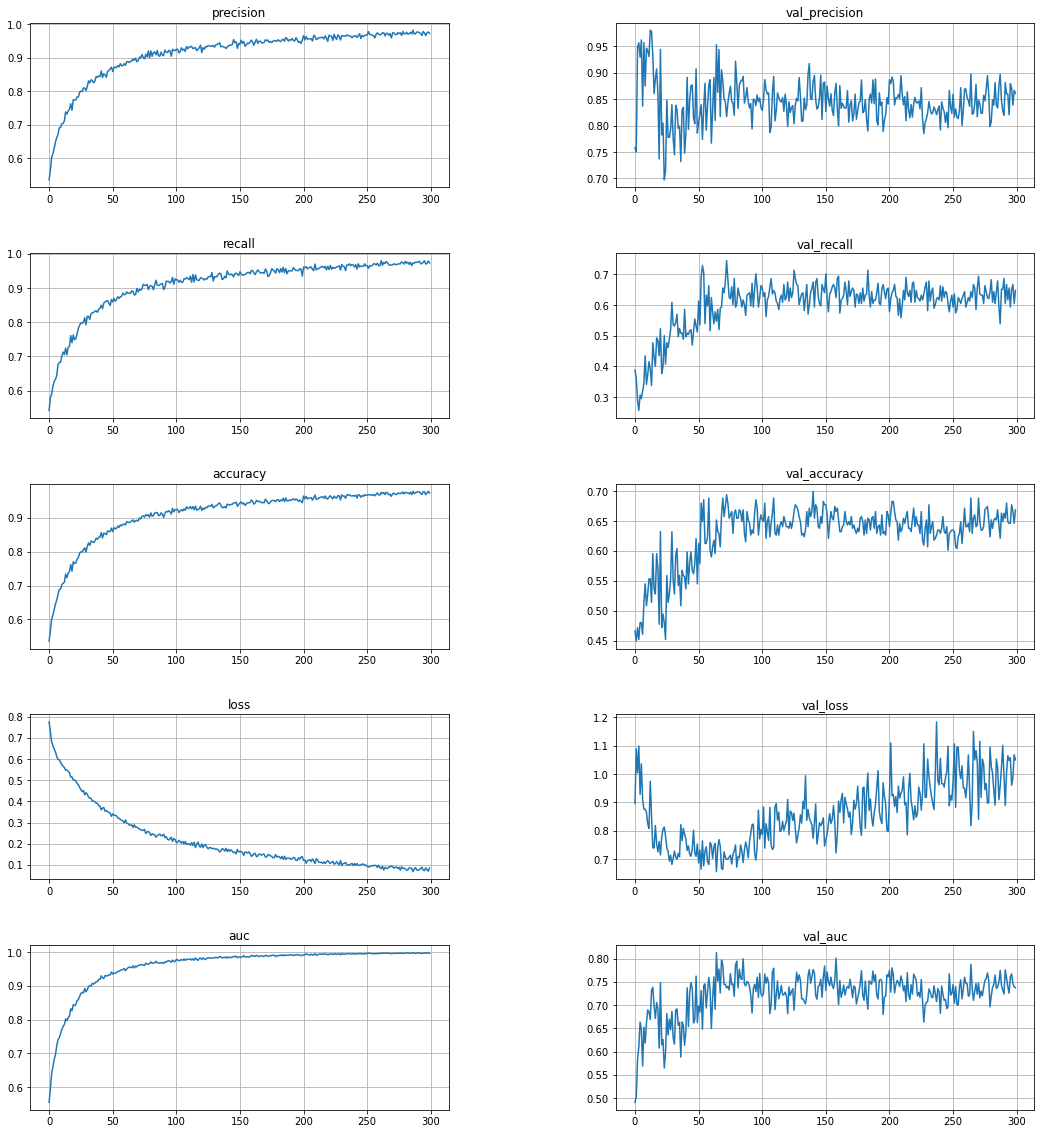

In [12]:
history_dict = history.history
history_dict.keys()

plotted_metrics = ['precision', 'recall', 'accuracy', 'loss', 'auc']

fig = plt.figure(figsize=(18, 4 * len(plotted_metrics)))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for idx, metric in enumerate(plotted_metrics):
    ax = plt.subplot(len(plotted_metrics), 2, 2*idx+1)
    plt.title(metric)
    plt.plot(history_dict[metric])
    ax.grid()
    
    ax = plt.subplot(len(plotted_metrics), 2, 2*idx+2)
    plt.title('val_{}'.format(metric))
    plt.plot(history_dict['val_{}'.format(metric)])
    ax.grid()

plt.show()

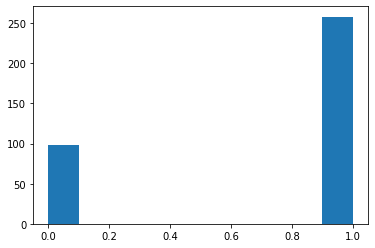

1.0    258
0.0     98
dtype: int64

In [13]:
plt.hist(Y_test)
plt.show()

pd.Series(Y_test).value_counts()